# MFDS Q3 Colab Notebook for Solutions

Make sure to run setup.sh before running the map codes.

In [2]:
# Importing the required libraries

import pandas as pd
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import datetime
import geopy
import re
import warnings

warnings.simplefilter('ignore')

sns.set()

## Note : All data here (unless specifically mentioned) are taken until 10/04/2020

------------------------------------------------------------------------------
------------------------------------------------------------------------------

### __Q1.__ Which age group is the most infected?

In [3]:
data = pd.read_csv('AgeGroupDetails.csv')
print("Most infected Age Group : "+str(data.iloc[data['TotalCases'].argmax()]['AgeGroup']))

Most infected Age Group : 20-29


### __Ans.__ From the above result, we can see that the age group of __20-29__ is the most infected, as it is the age group with most number of cases reported.

------------------------------------------------------------------------------
------------------------------------------------------------------------------

### __Q2.__ Plot graphs of the cases observed, recovered, deaths per day country-wise and state-wise.

In [4]:
# Reading the data

data = pd.read_csv('covid_19_india.csv')
data['Date'] = pd.to_datetime(data['Date'],format='%d/%m/%y')
data=data[data['Date']<=pd.to_datetime('10/04/20',format='%d/%m/%y')]
data = data.drop(columns=['Sno','Time','ConfirmedIndianNational','ConfirmedForeignNational'])
data = data[data['State/UnionTerritory'].map(lambda x: '#' not in x and x!='Unassigned')]

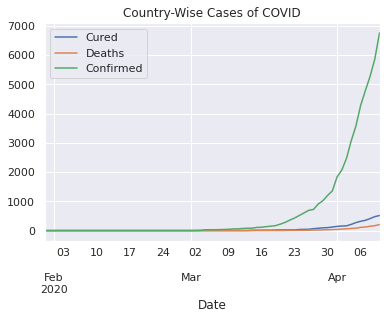

In [5]:
# Plotting country-wise
country_sum = data.groupby(['Date','State/UnionTerritory']).max().groupby('Date').sum()
country_sum.plot(title='Country-Wise Cases of COVID')
plt.show()

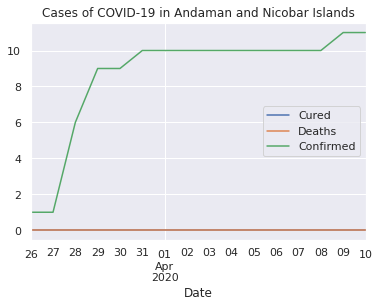

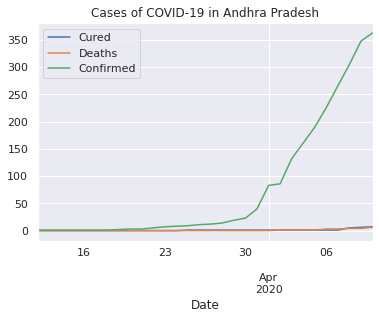

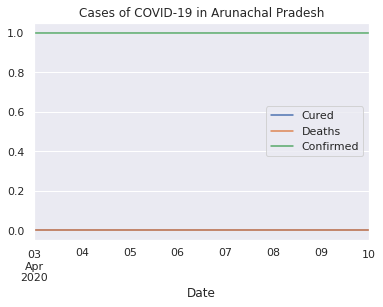

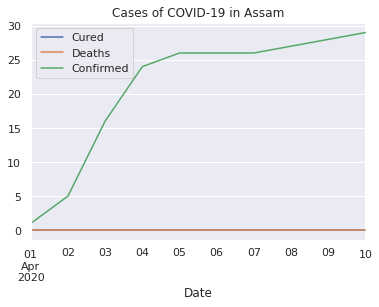

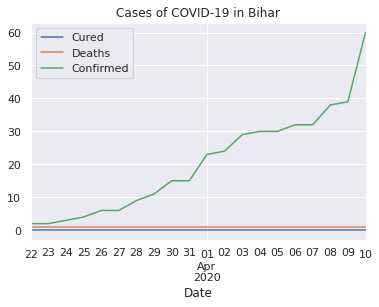

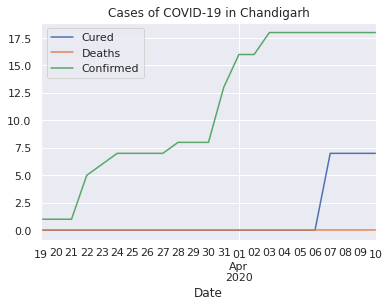

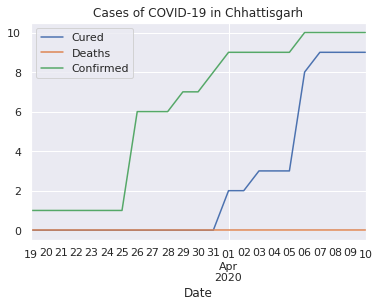

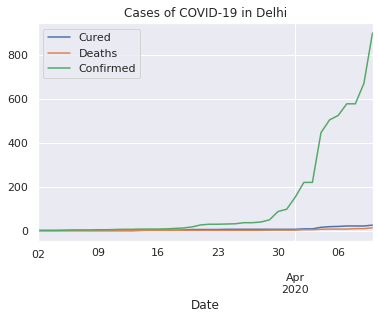

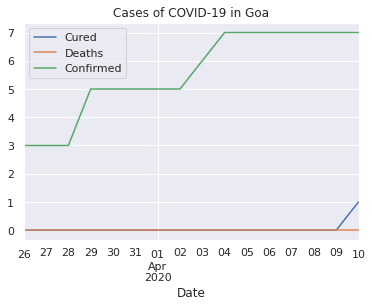

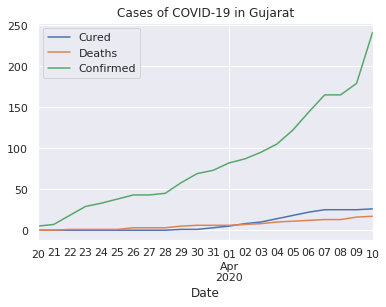

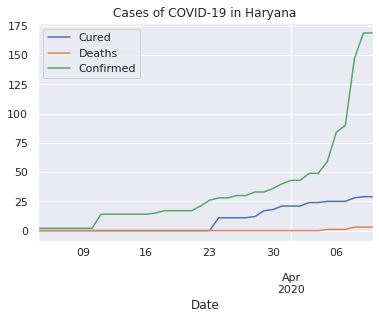

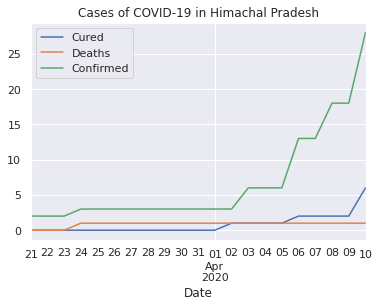

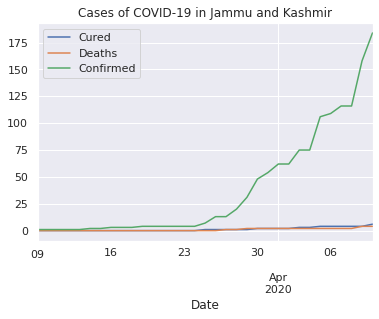

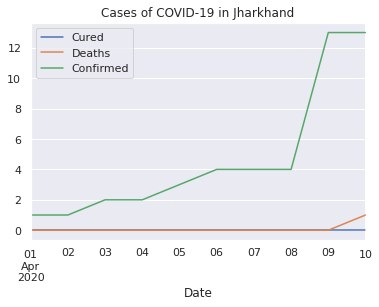

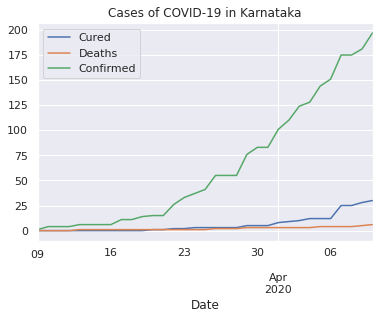

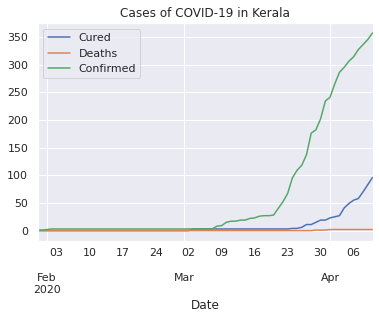

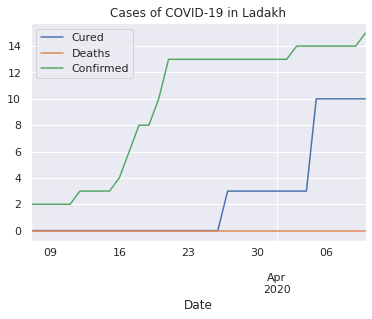

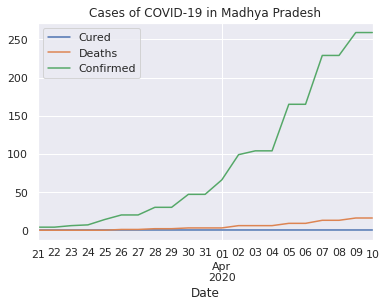

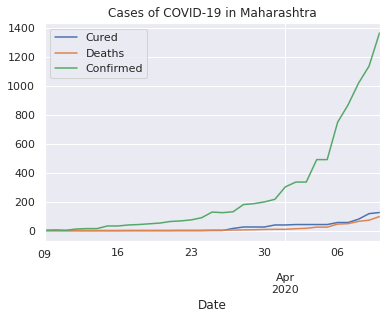

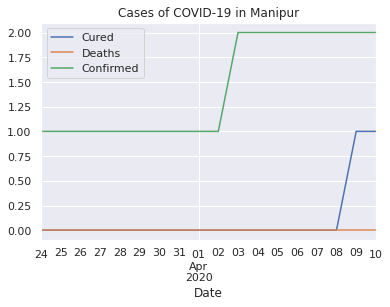

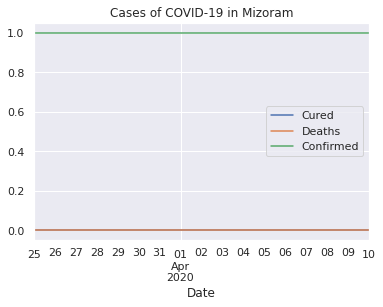

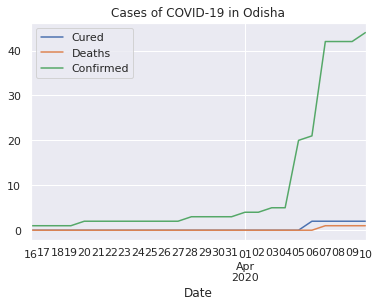

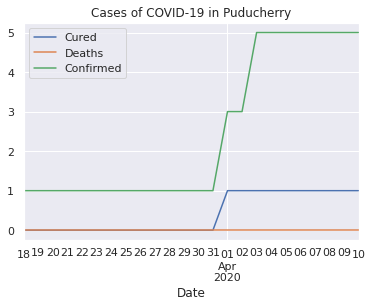

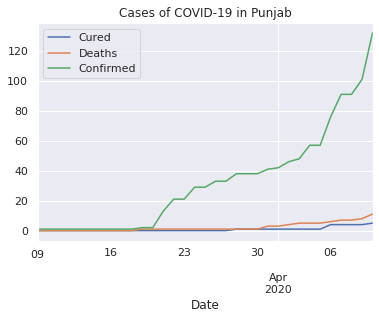

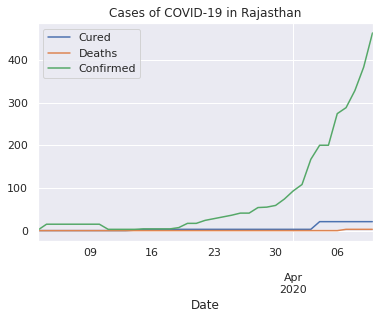

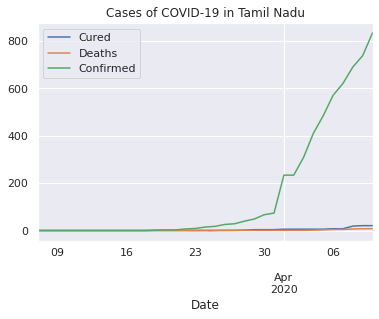

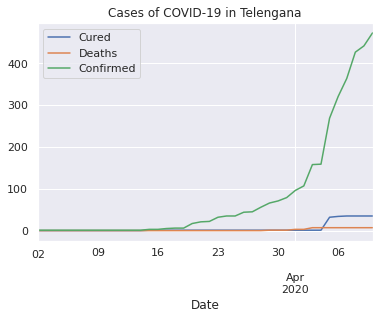

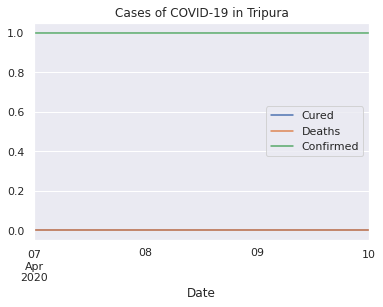

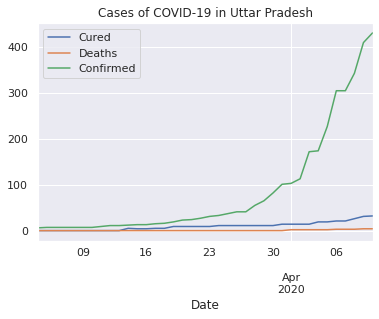

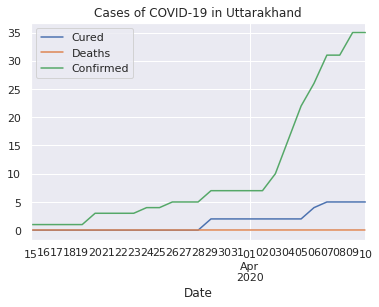

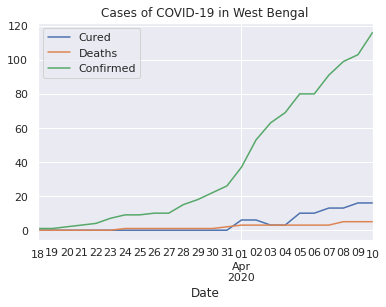

In [6]:
state_wise_sum = data.groupby(['State/UnionTerritory', 'Date']).max()
states = sorted(list(set(data['State/UnionTerritory'])))
for st in states:
    state_wise_sum.loc[st].plot(title='Cases of COVID-19 in ' + str(st))
    plt.show()

### __Ans.__ The required graphs are plotted above.

------------------------------------------------------------------------------
------------------------------------------------------------------------------

### Q3. Identify the positive cases on a state level. Quantify the intensity of virus spread for each state.

### Intensity = (No. of positive cases/population density)

In [7]:
data = pd.read_csv('covid_19_india.csv')
data = data[data['State/UnionTerritory'].map(
    lambda x: '#' not in x and x != 'Unassigned')]
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%y')
data = data[data['Date'] <= pd.to_datetime('10/04/20', format='%d/%m/%y')]
nation = pd.read_csv('population_india_census2011.csv')
confirmed_cases = dict(data.groupby('State/UnionTerritory').max()['Confirmed'])
density = dict(nation.groupby('State / Union Territory').max()["Density"])
intensity = {}
for i in confirmed_cases.keys():
    density_state = float(density[i].split('/')[0].replace(',', ''))
    intensity[i] = float(confirmed_cases[i]) / density_state
state_dict = {
    'State/Union Territory': list(intensity.keys()),
    'Intensity': [intensity[i] for i in intensity.keys()]
}
pd.DataFrame(state_dict).to_csv('intensity.csv', index=False)
print("\033[1m{:<27}  {:<10}\033[0m".format('State', 'Intensity'))
for k in intensity.keys():
    print('{:<27}  {:<10}'.format(k, intensity[k]))

State                        Intensity 
Andaman and Nicobar Islands  0.2391304347826087
Andhra Pradesh               1.198019801980198
Arunachal Pradesh            0.058823529411764705
Assam                        0.07304785894206549
Bihar                        0.0544464609800363
Chandigarh                   0.0019455252918287938
Chhattisgarh                 0.05291005291005291
Delhi                        0.07949013012304151
Goa                          0.017766497461928935
Gujarat                      0.7824675324675324
Haryana                      0.2949389179755672
Himachal Pradesh             0.22764227642276422
Jammu and Kashmir            1.8775510204081634
Jharkhand                    0.03140096618357488
Karnataka                    0.6175548589341693
Kerala                       0.41559953434225844
Ladakh                       5.357142857142858
Madhya Pradesh               1.097457627118644
Maharashtra                  3.736986301369863
Manipur                      0.01639344

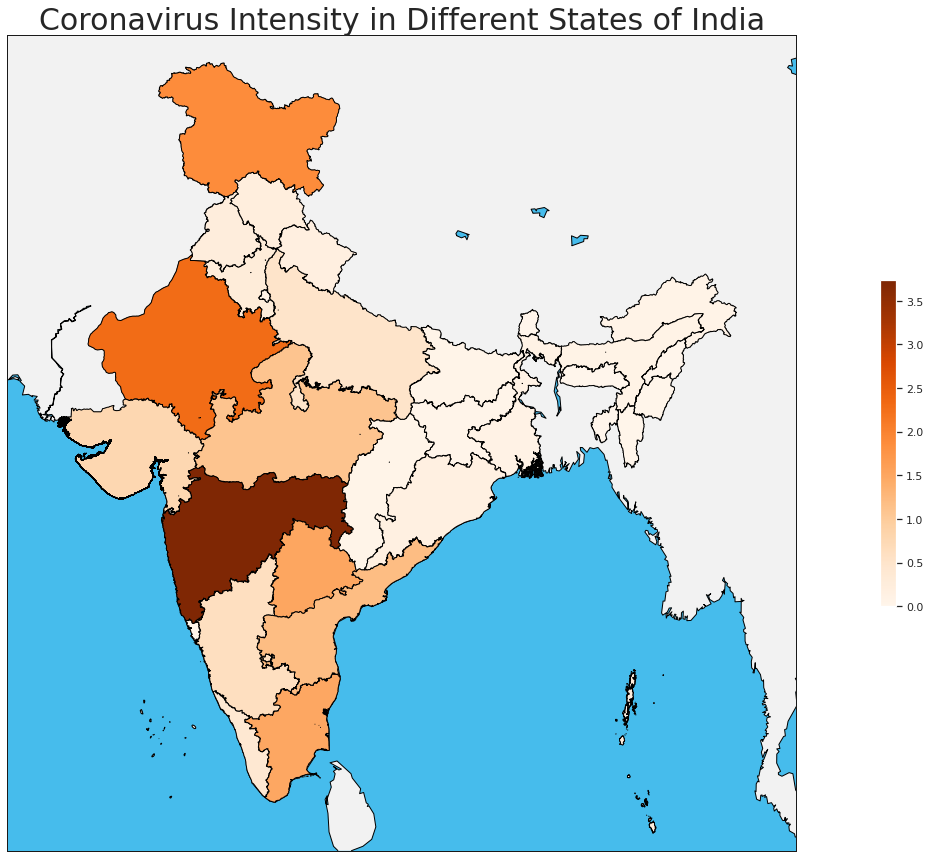

In [8]:
fig, ax = plt.subplots(figsize=(30, 15))
m = Basemap(
    resolution='l',  # c, l, i, h, f or None
    projection='merc',
    lat_0=54.5,
    lon_0=-4.36,
    llcrnrlon=66.,
    llcrnrlat=6.,
    urcrnrlon=100.,
    urcrnrlat=38.)
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2', lake_color='#46bcec')
m.drawcoastlines(color='#000000')
m.readshapefile('./Indian_States', 'IndStates')

state_set = set(i['st_nm'] for i in m.IndStates_info)
new_set = {}
for i in state_set:
    flag = True
    for j in state_dict['State/Union Territory']:
        if (i == j):
            flag = False
            new_set[i] = round(intensity[j], 3)
            break
    if flag:
        new_set[i] = 0
new_set['Arunanchal Pradesh'] = intensity['Arunachal Pradesh']
new_set['NCT of Delhi'] = intensity['Delhi']
new_set['Jammu & Kashmir'] = intensity['Jammu and Kashmir']
new_set['Telangana'] = intensity['Telengana']
new_set['Andaman & Nicobar Island'] = intensity['Andaman and Nicobar Islands']

df_poly = pd.DataFrame({
    'shapes': [
        matplotlib.patches.Polygon(np.array(shape), True)
        for shape in m.IndStates
    ],
    'intensity': [new_set[i['st_nm']] for i in m.IndStates_info]
})

shapes = df_poly['shapes']
cmap = plt.get_cmap('Oranges')

pc = matplotlib.collections.PatchCollection(shapes, zorder=2)

norm = matplotlib.colors.Normalize()

pc.set_facecolor(cmap(norm(df_poly['intensity'].values)))

pc.set_edgecolor('#000000')
ax.add_collection(pc)
mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

mapper.set_array(df_poly['intensity'])
plt.colorbar(mapper, shrink=0.4)
plt.title('Coronavirus Intensity in Different States of India', fontsize=30)
plt.show(m)

### Ans. The visualization of the coronavirus intensity in different states is shown above.

------------------------------------------------------------------------------
------------------------------------------------------------------------------

### Q4. List places in the country which are active hotspots/clusters as on 10.04.2020.
### Hotspot is defined as an area in a city where 10 or more people have been tested positive.

In [9]:
data = pd.read_csv('IndividualDetails.csv')
data['diagnosed_date'] = pd.to_datetime(
    data['diagnosed_date'], format='%d/%m/%Y')
date_before = pd.to_datetime('10/04/2020', format='%d/%m/%Y')
data = data[data['diagnosed_date'] <= date_before]
data = data.fillna('NA')
data['detected_area'] = [
    str(x) if len(str(x).strip()) > 0 and '-' not in str(x) and str(x) != 'NA'
    else str(y) if len(str(y).strip()) > 0 and '-' not in str(y)
    and str(y) != 'NA' else str(z) if len(str(z).strip()) > 0
    and '-' not in str(z) and str(z) != 'NA' else 'Unknown'
    for x, y, z in zip(data['detected_city'], data['detected_district'],
                       data['detected_state'])
]
cases = data.groupby('detected_area').count().sort_values(
    'id', ascending=False)
cases = cases[cases['id'] >= 10]
ids = cases['id']
cases_dict = {}
for i in cases.index:
    cases_dict[i] = ids[i]

In [10]:
print("\033[1m{:<27}  {:<10}\033[0m".format('Place', 'No. of cases'))
for k in cases_dict.keys():
    print('{:<27}  {:<10}'.format(k, cases_dict[k]))

Place                        No. of cases
Mumbai                       1001      
Delhi                        862       
Pune                         238       
Indore                       235       
Hyderabad                    214       
Jaipur                       205       
Ahmedabad                    190       
Chennai                      165       
Kasaragod                    162       
Bhopal                       116       
West Bengal                  89        
Agra                         88        
Thane                        83        
Vadodara                     59        
Coimbatore                   58        
Tirunelveli                  57        
Kannur                       56        
Dindigul                     50        
Nizamabad                    49        
Evacuees*                    46        
Gurugram                     46        
Bengaluru                    44        
Meerut                       44        
Jodhpur                      42       

The above is the list of places which are hotspot in tabular form scroll down for visulization of the hotspots in the India map 

In [11]:
loc_lat_lon = {}
locs_not_known = []

### Note: Repeatedly running the below code until all the required places have been downloaded.

In [12]:
# Note : Keep running until all the cities get filled. Ignore 'Not Found'

geolocator = geopy.geocoders.Nominatim(user_agent='test', timeout=20)
for i in cases.index:
    if '*' not in i and i not in loc_lat_lon.keys():
        location = geolocator.geocode(i)

        if location != None:
            # print(location.latitude,location.longitude)
            lat = location.latitude
            lon = location.longitude
            print('{:<27}  {:<10}'.format(i, "Found"))
            loc_lat_lon[i] = {'lat': lat, 'lon': lon}
        else:
            print('{:<27}  {:<10}'.format(i, "Not Found"))
            if i not in locs_not_known:
                locs_not_known.append(i)

Mumbai                       Found     
Delhi                        Found     
Pune                         Found     
Indore                       Found     
Hyderabad                    Found     
Jaipur                       Found     
Ahmedabad                    Found     
Chennai                      Found     
Kasaragod                    Found     
Bhopal                       Found     
West Bengal                  Found     
Agra                         Found     
Thane                        Found     
Vadodara                     Found     
Coimbatore                   Found     
Tirunelveli                  Found     
Kannur                       Found     
Dindigul                     Found     
Nizamabad                    Found     
Gurugram                     Found     
Bengaluru                    Found     
Meerut                       Found     
Jodhpur                      Found     
Srinagar                     Found     
Namakkal                     Found     


In [13]:
print(locs_not_known)
loc_lat_lon['S.P.S. Nellore'] = {'lat': 14.2581, 'lon': 79.9193}
loc_lat_lon['Shahid Bhagat Singh Nagar'] = {'lat': 31.0913, 'lon': 76.0392}
loc_lat_lon['Shopiyan'] = {'lat': 33.7594, 'lon': 74.8039}
loc_lat_lon['Nizamuddin area'] = {'lat': 28.5948, 'lon': 77.2491}

area_details = {}
for i in loc_lat_lon.keys():
    area_details[i] = {
        'Cases': cases_dict[i],
        'Lat': loc_lat_lon[i]['lat'],
        'Lon': loc_lat_lon[i]['lon']
    }

pd.DataFrame(area_details).to_csv('Areawise Cases.csv')

['S.P.S. Nellore', 'Nizamuddin area', 'Shopiyan', 'Shahid Bhagat Singh Nagar']


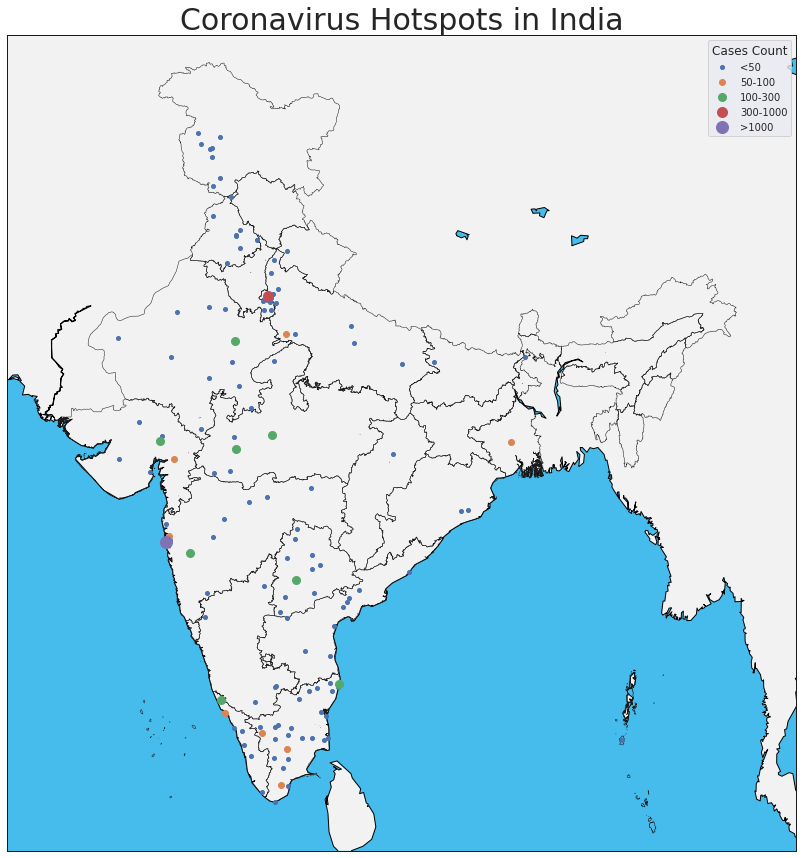

In [14]:
fig, ax = plt.subplots(figsize=(30, 15))
m = Basemap(
    resolution='l',  # c, l, i, h, f or None
    projection='merc',
    lat_0=54.5,
    lon_0=-4.36,
    llcrnrlon=66.,
    llcrnrlat=6.,
    urcrnrlon=100.,
    urcrnrlat=38.)
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2', lake_color='#46bcec')
m.drawcoastlines(color='#000000')
m.readshapefile('./Indian_States', 'IndStates')

data = pd.DataFrame(area_details).T

data_list = []
data = data.sort_values('Cases')
data_list.append((data[data['Cases'] < 50], '<50', 4))
data_list.append((data[(data['Cases'] >= 50) & (data['Cases'] < 100)],
                  '50-100', 6))
data_list.append((data[(data['Cases'] >= 100) & (data['Cases'] < 300)],
                  '100-300', 8))
data_list.append((data[(data['Cases'] >= 300) & (data['Cases'] < 1000)],
                  '300-1000', 10))
data_list.append((data[(data['Cases'] >= 1000)], '>1000', 12))

for i in data_list:
    (x, y) = m(np.array(i[0]['Lon']), np.array(i[0]['Lat']))
    m.plot(x, y, 'o', label=i[1], markersize=i[2])
plt.legend(title='Cases Count', loc=1, fontsize=10, fancybox=True)
plt.title('Coronavirus Hotspots in India', fontsize=30)
plt.show()

### Ans. The visualization of the coronavirus hotspot areas is shown above.

------------------------------------------------------------------------------
------------------------------------------------------------------------------

## Q5.Which states have the maximum change (consider increase and decrease separately) in number of hotspots on weekly basis from 20.03.2020 to 10.04.2020 (3 weeks).

In [15]:
data = pd.read_csv('IndividualDetails.csv')
data['diagnosed_date'] = pd.to_datetime(
    data['diagnosed_date'], format='%d/%m/%Y')
data = data.fillna('NA')
data['detected_area'] = [
    str(x) if len(str(x).strip()) > 0 and '-' not in str(x) and str(x) != 'NA'
    else str(y) if len(str(y).strip()) > 0 and '-' not in str(y)
    and str(y) != 'NA' else str(z) if len(str(z).strip()) > 0
    and '-' not in str(z) and str(z) != 'NA' else 'Unknown'
    for x, y, z in zip(data['detected_city'], data['detected_district'],
                       data['detected_state'])
]
states = set(data['detected_state'])
date_max = pd.to_datetime('10/04/2020', format='%d/%m/%Y')
date_min = pd.to_datetime('20/03/2020', format='%d/%m/%Y')
data_prev = data[(data['diagnosed_date'] < date_min)]
data_pres = data[(data['diagnosed_date'] < date_max)
                 & (data['diagnosed_date'] >= date_min)]
dates_lim = [date_min + datetime.timedelta(i) for i in [0, 7, 14, 21]]
data_prev_split = data_prev.groupby(['detected_state',
                                     'detected_area']).count()
data_prev_split = data_prev_split[data_prev_split['id'] >= 10]
states_dict_prev = {}
states_list = [{}, {}, {}, {}]

for state in states:
    states_dict_prev[state] = 0
for i in range(len(data_prev_split)):
    states_dict_prev[data_prev_split.iloc[[i]].index[0][0]] += 1

states_list[0] = states_dict_prev
for i in range(3):
    for state in states:
        states_list[i + 1][state] = 0
    data_ranged = data_pres[(data_pres['diagnosed_date'] >= dates_lim[i])
                            & (data_pres['diagnosed_date'] < dates_lim[i + 1])]
    data_ranged_split = data_ranged.groupby(
        ['detected_state', 'detected_area']).count()
    data_ranged_split = data_ranged_split[data_ranged_split['id'] >= 10]
    for q in range(len(data_ranged_split)):
        states_list[i + 1][data_ranged_split.iloc[[q]].index[0][0]] += 1

max_inc_data = {'Week': [], 'States': [], 'Amount Increased': []}
max_dec_data = {'Week': [], 'States': [], 'Amount Decreased': []}

for i in range(3):
    max_inc = -1
    max_inc_state = []
    max_dec = 10
    max_dec_state = []

    for (p, q) in zip(
            sorted(states_list[i].keys()), sorted(states_list[i + 1].keys())):
        diff = states_list[i + 1][q] - states_list[i][p]
        if (diff > max_inc):
            max_inc = diff
            max_inc_state = [p]
        elif (diff == max_inc):
            max_inc_state.append(p)
        if (diff < max_dec):
            max_dec = diff
            max_dec_state = [p]
        elif (diff == max_dec):
            max_dec_state.append(p)

    max_inc_data['Week'].append(
        str(dates_lim[i].strftime('%d/%m/%y')) + '-' +
        str(dates_lim[i + 1].strftime('%d/%m/%y')))
    max_inc_data['States'].append(",".join(max_inc_state))
    max_inc_data['Amount Increased'].append(max_inc)

    max_dec_data['Week'].append(
        str(dates_lim[i].strftime('%d/%m/%y')) + '-' +
        str(dates_lim[i + 1].strftime('%d/%m/%y')))
    max_dec_data['States'].append(",".join(max_dec_state))
    max_dec_data['Amount Decreased'].append(abs(max_dec))

print('States with Maximum Increase\n')
display(pd.DataFrame(max_inc_data).set_index('Week'))
print('\n\nStates with Maximum Decrease\n')
display(pd.DataFrame(max_dec_data).set_index('Week'))

States with Maximum Increase



,States,Amount Increased
Week,,
20/03/20-27/03/20,Kerala,3
27/03/20-03/04/20,Tamil Nadu,12
03/04/20-10/04/20,Telangana,10




States with Maximum Decrease



,States,Amount Decreased
Week,,
20/03/20-27/03/20,"Haryana,Telangana,Uttar Pradesh",1
27/03/20-03/04/20,Kerala,1
03/04/20-10/04/20,Andhra Pradesh,2


### Ans.

### - State With Maximum Increase in Hotspots in Week Between 20/03/20 and 27/03/20 is __Kerala__ with a increase of 3 hotspots from previous week
### - State(s) With Maximum Decrease in Hotspots in Week Between 20/03/20 and 27/03/20 is __Haryana,Telangana,Uttar Pradesh__ with a decrease of 1 hotspot from previous week
### - State With Maximum Increase in Hotspots in Week Between 27/03/20 and 03/04/20 is __Tamil Nadu__ with a increase of 12 hotspots from previous week
### - State With Maximum Decrease in Hotspots in Week Between 27/03/20 and 03/04/20 is __Kerala__ with a decrease of 1 hotspot from previous week
### - State With Maximum Increase in Hotspots in Week Between 03/04/20 and 10/04/20 is __Telangana__ with a increase of 10 hotspots from previous week
### - State With Maximum Decrease in Hotspots in Week Between 03/04/20 and 10/04/20 is __Andhra Pradesh__ with a decrease of 2 hotspots from previous week

------------------------------------------------------------------------------
------------------------------------------------------------------------------

## Q6. For the given data, identify cases with international travel history (primary case), personal contact with primary case (secondary case). Cases which do not fall in the primary and secondary fall into tertiary case. Quantify them based on the percentage for the top 5 states with maximum cases till 10.04.2020.

Cases (in percent)
State       Case Type                   
Maharashtra Primary                5.21%
            Secondary              3.37%
            Tertiary              91.42%
Tamil Nadu  Primary               67.03%
            Secondary              5.04%
            Tertiary              27.94%
Delhi       Primary                7.64%
            Secondary              1.25%
            Tertiary              91.11%
Telangana   Primary                9.13%
            Secondary              0.85%
            Tertiary              90.02%
Rajasthan   Primary               13.17%
            Secondary             11.88%
            Tertiary              74.95%

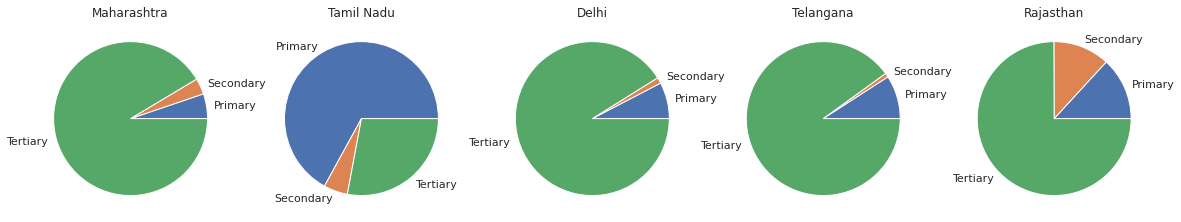

In [16]:
data = pd.read_csv('IndividualDetails.csv', index_col='id')
data['diagnosed_date'] = pd.to_datetime(
    data['diagnosed_date'], format='%d/%m/%Y')
data = data.fillna('NA')
date_max = pd.to_datetime('10/04/2020', format='%d/%m/%Y')
data = data[(data['diagnosed_date'] < date_max)]
travel_list = ['Travelled', 'Travel', 'international', 'Airport', 'returned']
cases = []
for i in range(len(data)):
    notes = data.iloc[i]['notes']
    if (re.compile('|'.join(travel_list), re.IGNORECASE).search(str(notes)) !=
            None):
        cases.append('Primary')
    else:
        p = re.findall('P[0-9]+', str(notes))
        if (len(p) != 0):
            near = int(p[0].replace('P', ''))
            if (near < len(cases)):
                if (cases[near - 1] == 'Primary'):
                    cases.append('Secondary')
                else:
                    cases.append('Tertiary')
            else:
                cases.append('Tertiary')
        else:
            family = [
                "family", "accompanied", "relative", "neighbour", "medical",
                "tenant", "contact", "friends", "wife", "daughter", "father",
                "mother", "son in law", "co-passenger", "co-passengers",
                "cab driver", "son", "spouse", "doctor of", "of", "contracted",
                "boss", "related", "brother", "cook", "compounder", "hospital",
                "staff", "sister", "driver", "airport", "worked", "worker",
                "medical college", "uncle", "aunt", "nurse", "attended",
                "husband", "security", "siblings", "grandchildren", "related",
                "travel", "cousin", "attended", "local transmission",
                "mother&son", "roommate"
            ]
            if re.compile('|'.join(family), re.IGNORECASE).search(
                    str(notes)) != None:
                cases.append('Secondary')
            else:
                cases.append('Tertiary')
data['case_type'] = cases
data_group = data.groupby(['detected_state', 'case_type']).count()
data_state_group = data.groupby('detected_state').count().nlargest(
    5, 'government_id')
data_max_states = pd.DataFrame(data_group.loc[list(
    data_state_group.index)]['government_id'])
data_max_states = data_max_states.reset_index().rename(
    columns={
        'detected_state': 'State',
        'case_type': 'Case Type',
        'government_id': 'Cases (in percent)'
    }).groupby(['State', 'Case Type']).sum().groupby(
        level=0).apply(lambda x: round(100 * x / float(x.sum()), 2))
data_max_states['Cases (in percent)'] = data_max_states[
    'Cases (in percent)'].apply(lambda x: str(x) + '%')
display(data_max_states.reindex(list(data_state_group.index), level=0))
print('\n\n')
cases_list = []
for i in list(data_state_group.index):
    case_type = dict(data_group.T[i].T['government_id'])
    cases_list.append(
        np.array(list(case_type.values())) / sum(case_type.values()))
cases_list = np.array(cases_list)
states = list(data_state_group.index)
types = ['Primary', 'Secondary', 'Tertiary']
fig, axs = plt.subplots(1, 5)
fig.set_size_inches(20, 8)
for i in range(len(states)):
    axs[i].pie(cases_list[i], labels=types)
    axs[i].set_title(states[i])
plt.show()

### Ans. The percentage of Primary, Secondary and Tertiary Cases in top 5 affected states are : 

### __Note__ : Considering cases with unknown history as Tertiary

### __Maharashtra__
- ###   Primary : 5.21%
- ### 	Secondary : 3.37%
- ### 	Tertiary : 91.42%

### __Tamil Nadu__
- ### 	Primary : 67.03%
- ### 	Secondary : 5.04%
- ### 	Tertiary : 27.94%

### __Delhi__
- ### 	Primary : 7.64%
- ### 	Secondary : 1.25%
- ### 	Tertiary : 91.11%

### __Telangana__
- ### 	Primary : 9.13%
- ### 	Secondary : 0.85%
- ### 	Tertiary : 90.02%

### __Rajasthan__
- ### 	Primary : 13.17%
- ### 	Secondary : 11.88%
- ### 	Tertiary : 74.95%

------------------------------------------------------------------------------
------------------------------------------------------------------------------

## Q7) Find out the number of additional labs needed from the current existing labs (assume 100 tests per day per lab) with an increase rate of 10% cases per day from 11.04.2020- 20.04.2020. List out any further assumptions considered.


In [17]:
data_lab = pd.read_csv('ICMRTestingLabs.csv')
data_test = pd.read_csv("ICMRTestingDetails.csv")
data_test['DateTime'] = pd.to_datetime(
    data_test['DateTime'], format='%d/%m/%y %H:%M')
n_labs = len(data_lab)
ini_date = '10/04/20'
fin_date = '20/04/20'
ini_date = pd.to_datetime(ini_date, format='%d/%m/%y')
fin_date = pd.to_datetime(fin_date, format='%d/%m/%y')

# No. of samples tested until the date ini_date from start given by ini_samp

ini_samp_test = data_test[data_test['DateTime'].dt.date ==
                          ini_date].TotalSamplesTested.values

# Assuming that 10% increase in cases per date is the number of samples and not number of individuals

per_inc = 10
no_days = (fin_date - ini_date).days
# Assuming compund increase in number of cases

fin_samp_test = (ini_samp_test * (1 + per_inc / 100)**no_days)[0]

# Assuming each lab can process 100 test per day.

tot_n_labs = round(fin_samp_test / 100) + 1
req_n_labs = tot_n_labs - n_labs
print("The number of additional labs required are " + str(req_n_labs))

The number of additional labs required are 3918.0



## Assuming that 10% increase in cases per date is the number of samples the labs receive and not number of individuals, The number of additional labs required are __3918.0__

------------------------------------------------------------------------------
------------------------------------------------------------------------------

## Q8) Plot the number of cases starting from 1st March - 10th April. Based on this plot can you comment on the popular notion of ‘flattening the curve’.





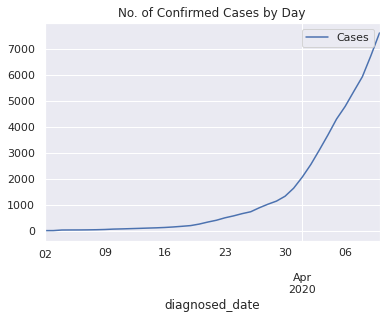

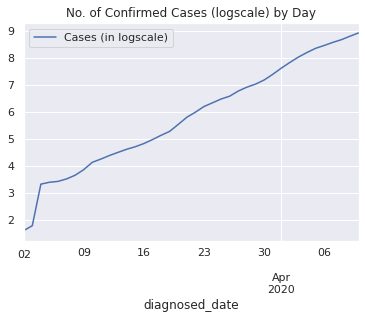

In [18]:
data = pd.read_csv("IndividualDetails.csv")
data['diagnosed_date'] = pd.to_datetime(
    data['diagnosed_date'], format='%d/%m/%Y')
start_date = pd.to_datetime('01/03/2020', format='%d/%m/%Y')
end_date = pd.to_datetime('10/04/2020', format='%d/%m/%Y')
data_dates = data.groupby('diagnosed_date').count().cumsum()
data_dates = data_dates[(data_dates.index >= start_date)
                        & (data_dates.index <= end_date)]
data_dates = pd.DataFrame(
    data_dates['id'].values, index=data_dates.index, columns=['Cases'])
data_dates.plot(title='No. of Confirmed Cases by Day')
plt.show()
data_dates_log = pd.DataFrame(
    np.log(data_dates['Cases'].values),
    index=data_dates.index,
    columns=['Cases (in logscale)'])
data_dates_log.plot(title='No. of Confirmed Cases (logscale) by Day')
plt.show()

### Since COVID-19 is a highly contagious virus, the rate of increase in the number of cases is a preferable parameter for judging the curve compared to judging it from the total number of cases. The above graph shows the number of COVID-19 cases visually, which is increasing at an almost exponential rate. The aim of flattening the curve is to reduce this rate of increase of cases, by making the rate of growth in cases nearly zero. By making the rate of increase zero, we can ensure that the increase in COVID 19 cases can be stopped, and treat each of the individual cases effectively.

------------------------------------------------------------------------------
------------------------------------------------------------------------------

## Q9) As we know, social distancing is the best option to avoid the spread. Based on the time series data (covid_19_india.csv), can you suggest how successful the 21 days lockdown has been?


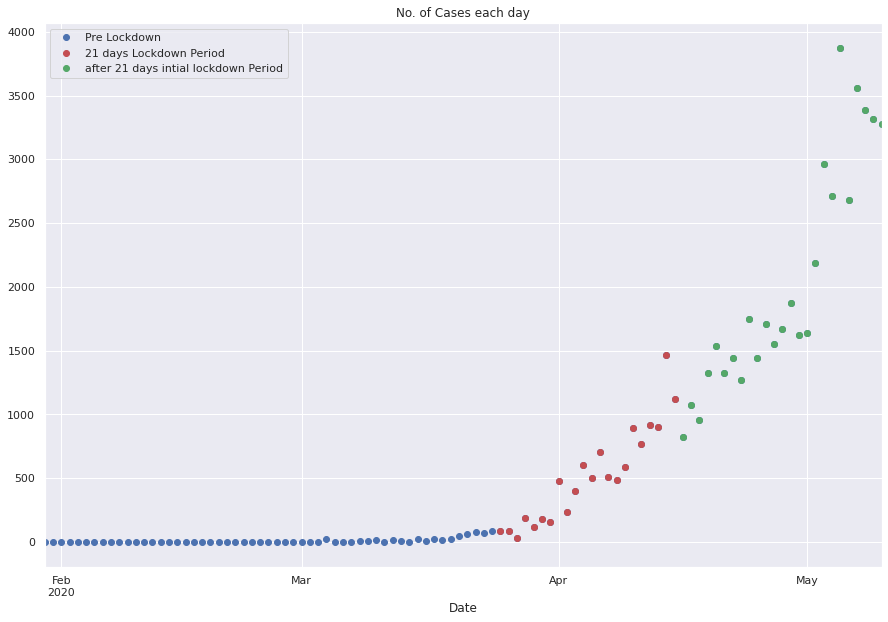

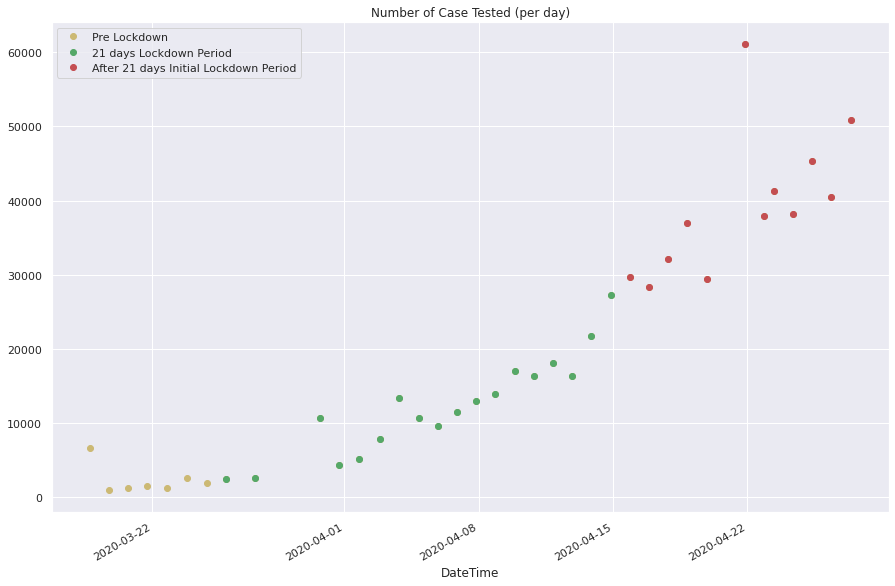

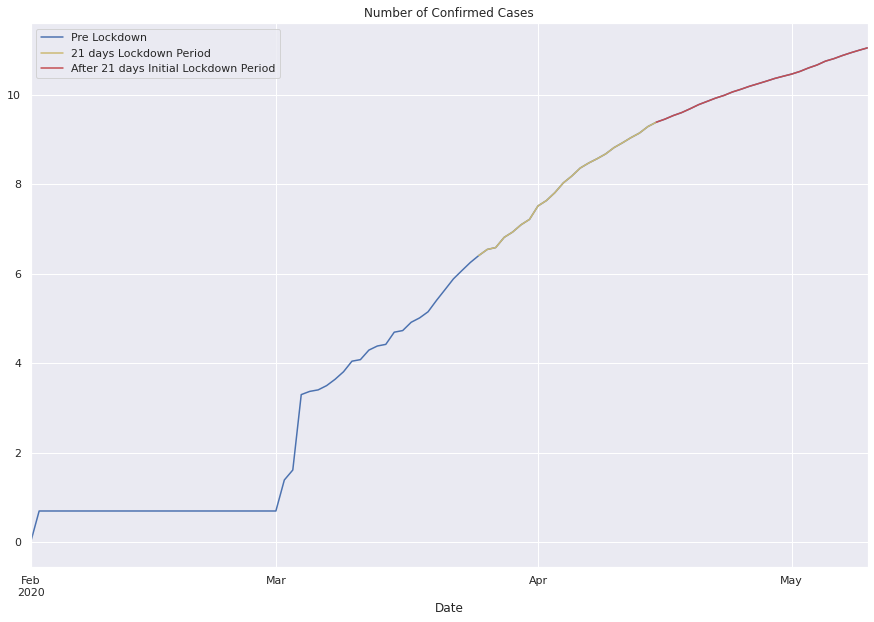

In [19]:
data = pd.read_csv('covid_19_india.csv')
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%y')
data = data.drop(columns=[
    'Sno', 'Time', 'ConfirmedIndianNational', 'ConfirmedForeignNational'
])
data = data[data['State/UnionTerritory'].map(
    lambda x: '#' not in x and x != 'Unassigned')]
country_sum = data.groupby(
    ['Date',
     'State/UnionTerritory']).max().groupby('Date').sum().diff(1).fillna(0)

plt.figure(figsize=(15, 10))
country_sum['Confirmed'].plot(style='bo', label='Pre Lockdown')
start_date = pd.to_datetime('25/03/2020', format='%d/%m/%Y')
end_date_1 = pd.to_datetime('15/04/2020', format='%d/%m/%Y')
country_sum_lock = country_sum[(country_sum.index >= start_date)
                               & (country_sum.index <= end_date_1)]
country_sum_lock['Confirmed'].plot(
    style='ro', label='21 days Lockdown Period', title='No. of Cases each day')
country_ext_lock = country_sum[country_sum.index > end_date_1]
country_ext_lock['Confirmed'].plot(
    style='go',
    label='after 21 days intial lockdown Period',
    title='No. of Cases each day')
plt.legend()
plt.show()

plt.figure(figsize=(15, 10))
data_test = pd.read_csv('ICMRTestingDetails.csv').fillna(0)
data_test['DateTime'] = pd.to_datetime(
    data_test['DateTime'], format='%d/%m/%y %H:%M')
data_test = data_test[data_test['TotalSamplesTested'] != 0].groupby(
    'DateTime').sum().diff(1)
data_test['TotalSamplesTested'].plot(
    style='yo', title='Number of Case Tested (per day)', label='Pre Lockdown')
data_test_lock = data_test[(data_test.index >= start_date)
                           & (data_test.index <= end_date_1)]
data_test_lock['TotalSamplesTested'].plot(
    style='go',
    title='Number of Case Tested (per day)',
    label='21 days Lockdown Period')
data_test_ext_lock = data_test[data_test.index >= end_date_1]
data_test_ext_lock['TotalSamplesTested'].plot(
    style='ro',
    title='Number of Case Tested (per day)',
    label='After 21 days Initial Lockdown Period')
plt.legend()
plt.show()

plt.figure(figsize=(15, 10))
a = pd.DataFrame(country_sum['Confirmed'].cumsum())
a = a[a['Confirmed'] != 0]
a['Confirmed'] = np.log(a['Confirmed'])
start_date = pd.to_datetime('25/03/2020', format='%d/%m/%Y')
end_date = pd.to_datetime('15/04/2020')
c = a[(a.index >= start_date) & (a.index <= end_date)]
d = a[a.index >= end_date]
a['Confirmed'].plot(
    style='b', title='Number of Confirmed Cases', label='Pre Lockdown')
c['Confirmed'].plot(
    style='y',
    title='Number of Confirmed Cases',
    label='21 days Lockdown Period')
d['Confirmed'].plot(
    style='r',
    title='Number of Confirmed Cases',
    label='After 21 days Initial Lockdown Period')
plt.legend()
plt.show()

### After a thorough analysis of the data, visualized as graphs shown above, we concluded that the lockdown has been partially successful. The third graph above shows the variation in the rate of increase in the number of Covid-19 cases in the log scale. For the portion following the 21-day lockdown period, the curve is flatter than the expected linear slope by extrapolating the data. This shows that the 21-day lockdown has been partly successful.
### The first two graphs, where we plot the number of cases show an increase in the number of cases every day, but when we combine with the information from the third graph, we can see that the rate of increase in cases is decreasing. There are many reasons behind the overall increase in the number of cases, one of them is the increase in the number of Covid-19 tests per day. Thus with the given data, it is not possible to conclusively conclude whether the lockdown has been successful or not. We conclude that the lockdown is partially successful, and following measures like social distancing and maintaining personal hygiene will go a long way in helping us combat the deadly virus.
